# Pricing Data Analysis

## Data Sources

`fullfillment-dwh-production:dynamic_pricing_logs.dynamic_pricing_request_response`: contains information about delivery fees shown on the restaurant listing page (RLP) and clicks on the restaurant detail page (RDP) per session  
`fulfillment-dwh-production:cl.oders`: contains order data  
`foodorapremiumanalytics:dps_dashboard.dpsSession_orderId_map`: contains mapping of session_id to platform_order_code

## Processed Data

Based on this table several other tables were created under the dataset `fullfillment-dwh-staging:pricing`

### session_details

* contains info about the RDP for a specific session
* in particular customer lat/lon and delivery_fee

In [3]:
session_details_query = '''
    CREATE TEMP FUNCTION parse_customer(payload STRING)
    RETURNS STRUCT<session_id string, latitude float64, longitude float64>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE TEMP FUNCTION parse_vendor(payload STRING)
    RETURNS STRUCT<id string, delivery_fee STRUCT<total STRING>, minimum_order_value STRUCT<total STRING>>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE OR REPLACE TABLE `pricing.session_details`
    PARTITION BY created_date

    AS
      SELECT
        region,
        created_at, 
        parse_customer(JSON_EXTRACT(request, "$.customer")) as customer,
        parse_vendor(JSON_EXTRACT(response, "$.vendor")) vendor,
        PARSE_TIMESTAMP("%FT%H:%M:%S", SUBSTR(JSON_EXTRACT_SCALAR(request, "$.promised_delivery_time"), 0, 19)) as promised_delivery_time,
        created_date
      FROM
        `dynamic_pricing_logs.dynamic_pricing_request_response`
      WHERE
        created_date >= '2020-01-01'
        AND endpoint_name = 'singleFee'
'''

In [ ]:
session_details_full_query = '''CREATE TEMP FUNCTION parse_customer(payload STRING)
    RETURNS STRUCT<session_id string, latitude float64, longitude float64>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE TEMP FUNCTION parse_vendor(payload STRING)
    RETURNS STRUCT<id string, delivery_fee STRUCT<total STRING>, minimum_order_value STRUCT<total STRING>>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE OR REPLACE TABLE `pricing.session_details_march`
    PARTITION BY created_date

    AS
      SELECT
        region,
        created_at, 
        parse_customer(JSON_EXTRACT(request, "$.customer")) as customer,
        parse_vendor(JSON_EXTRACT(response, "$.vendor")) vendor,
        PARSE_TIMESTAMP("%FT%H:%M:%S", SUBSTR(JSON_EXTRACT_SCALAR(request, "$.promised_delivery_time"), 0, 19)) as promised_delivery_time,
        created_date
      FROM
        `dynamic_pricing_logs.dynamic_pricing_request_response`
      WHERE
        created_date >= '2020-01-01'
        AND endpoint_name = 'singleFee'
'''


### session_listings

* contains info about the RLP for a specific session
* i.e. all delivery fees for all vendors shown to that customer

In [4]:
session_listings_query = '''
    CREATE TEMP FUNCTION parse_customer(payload STRING)
    RETURNS STRUCT<session_id string, latitude float64, longitude float64>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE TEMP FUNCTION parse_vendors(payload STRING)
    RETURNS ARRAY<STRUCT<id string, delivery_fee STRUCT<total STRING>, minimum_order_value STRUCT<total STRING>>>
    LANGUAGE js AS
    """
        return JSON.parse(payload);
    """;

    CREATE OR REPLACE TABLE `pricing.session_listings`
    PARTITION BY created_date

    AS
      SELECT
        region,
        created_at, 
        parse_customer(JSON_EXTRACT(request, "$.customer")) as customer,
        parse_vendors(JSON_EXTRACT(response, "$.vendors")) vendors,
        PARSE_TIMESTAMP("%FT%H:%M:%S", SUBSTR(JSON_EXTRACT_SCALAR(request, "$.promised_delivery_time"), 0, 19)) as promised_delivery_time,
        created_date
      FROM
        `dynamic_pricing_logs.dynamic_pricing_request_response`
      WHERE
        created_date >= '2020-03-01'
        AND endpoint_name = 'multipleFee'
'''

In [ ]:
session_listings_full_query = '''
CREATE TEMP FUNCTION
  parse_customer(payload STRING)
  RETURNS STRUCT<session_id string,
  latitude float64,
  longitude float64>
  LANGUAGE js AS """
        return JSON.parse(payload);
    """;
CREATE TEMP FUNCTION
  parse_vendor(payload STRING)
  RETURNS STRUCT<id string,
  delivery_fee STRUCT<total STRING>,
  minimum_order_value STRUCT<total STRING>>
  LANGUAGE js AS """
        return JSON.parse(payload);
    """;
CREATE OR REPLACE TABLE
  `pricing.session_details`
PARTITION BY
  created_date AS
WITH
  raw_data AS (
  SELECT
    region,
    created_at,
    parse_customer(JSON_EXTRACT(request,
        "$.customer")) AS customer,
    parse_vendor(JSON_EXTRACT(response,
        "$.vendor")) vendor,
    PARSE_TIMESTAMP("%FT%H:%M:%S", SUBSTR(JSON_EXTRACT_SCALAR(request,
          "$.promised_delivery_time"), 0, 19)) AS promised_delivery_time,
    created_date
  FROM
    `dynamic_pricing_logs.dynamic_pricing_request_response`
  WHERE
    created_date >= '2020-01-01'
    AND endpoint_name = 'singleFee' ),
  ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY customer.session_id, created_at) AS rank_num
  FROM
    raw_data )
SELECT
  * EXCEPT(rank_num)
FROM
  ranked
WHERE
  rank_num=1
        '''

### session_order_map

* maps session id to potential hurrier order

In [9]:
session_order_map_query = '''
CREATE OR REPLACE TABLE pricing.session_order_map
PARTITION BY date
AS*
    SELECT
        date,
        COALESCE(dpsSessionId_transaction, dpsSessionId_first, dpsSessionId_last) AS session_id,
        order_code_google AS platform_order_code
    FROM
        `foodoraanalyticspremium.dps_dashboard.dpsSession_orderId_map_v2`
'''

### all_sessions

* contains the merge of the above tables
* plus the mapping to the platform_order_code

In [128]:
all_sessions_query = '''
    CREATE OR REPLACE TABLE `pricing.all_sessions`
    PARTITION BY created_date
    AS

    WITH tmp AS (
        SELECT
            sd.*,
            som.platform_order_code,
            sl.* except(region, created_at, created_date, customer, promised_delivery_time),
            rank() OVER (PARTITION BY sl.customer.session_id ORDER BY sl.created_at DESC) as rank_num
        FROM
            `pricing.session_details` sd
            INNER JOIN `pricing.session_listings` sl ON sd.customer.session_id = sl.customer.session_id AND sd.created_date = sl.created_date AND sd.region = sl.region AND sl.created_at < sd.created_at
            INNER JOIN `pricing.session_order_map` som ON som.date = sd.created_date AND som.session_id = sd.customer.session_id
        WHERE
            STARTS_WITH(som.platform_order_code, sd.vendor.id)
    )

    SELECT * EXCEPT (rank_num) FROM tmp WHERE rank_num = 1
'''

In [ ]:
all_sessions_full_query = '''
CREATE OR REPLACE TABLE `pricing.all_sessions_full`
    PARTITION BY created_date AS

WITH tmp AS (
SELECT
  sd.*,
  som.platform_order_code,
  sl.* EXCEPT(region,
    created_at,
    created_date,
    customer,
    promised_delivery_time),
    RANK() OVER (PARTITION BY sl.customer.session_id ORDER BY sl.created_at DESC) AS rank_num
FROM
  `fulfillment-dwh-production.pricing.session_listings` sl
  --,UNNEST(sl.vendors) v
INNER JOIN
  `fulfillment-dwh-production.pricing.session_details` sd
ON
  sd.customer.session_id = sl.customer.session_id
  AND sd.created_date = sl.created_date
  AND sd.region = sl.region
  AND sl.created_at < sd.created_at
INNER JOIN `pricing.session_order_map` som ON som.date = sd.created_date AND som.session_id = sd.customer.session_id
WHERE STARTS_WITH(som.platform_order_code, sd.vendor.id)
AND sd.vendor.id IN (select id from sl.vendors)
and
  sd.created_date >= '2020-02-07'
and 
sl.created_date >= '2020-02-07'
and
som.date >= '2020-02-07'
  )
SELECT * EXCEPT (rank_num) FROM tmp WHERE rank_num = 1
'''

TODO: Why is the where condition required? the join on session_id should be unique

## Some testing

In [16]:
'''%%bigquery conversion_rates

with session_data AS (
  SELECT
    s.region,
    s.created_date,
    s.created_at,
    s.customer as session_customer,
    s.vendor as session_vendor,
    --o.customer.location as customer_location,
    FLOOR(st_distance(o.vendor.location, o.customer.location) / 200) * 200 as distance_bucket,
    ARRAY_LENGTH(s.vendors) as num_session_vendor_list,
    s.vendors as session_vendor_list,
    FLOOR(hzs.delay / 5) * 5 as delay_bucket,
    --FLOOR((o.timings.assumed_actual_preparation_time /60) / 5) * 5 as preptime_bucket
FROM
    `pricing.session_data_new_test` s
    INNER JOIN cl.orders o ON
      o.created_date = s.created_date
      AND o.platform_order_code = s.platform_order_code
    
    LEFT JOIN `dl.hurrier_zone_stats` hzs ON
      hzs.geo_zone_id = o.zone_id
      AND hzs.created_date = o.created_date
      AND hzs.country_code = o.country_code
      AND TIMESTAMP_TRUNC(o.order_placed_at, MINUTE) = TIMESTAMP_TRUNC(hzs.created_at, MINUTE)
  WHERE
    s.created_date >= "2020-03-01"
    AND o.created_date = "2020-03-01"
    AND hzs.created_date = "2020-03-01"
    AND o.country_code = "sg"
    AND hzs.country_code = "sg"
),
vendors_shown AS (
  SELECT
    v.id AS vendor_code,
    v.delivery_fee.total AS delivery_fee,
    FLOOR(ST_DISTANCE(clv.location, ST_GEOGPOINT(s.session_customer.longitude, s.session_customer.latitude)) / 200) * 200 AS distance_bucket,
    s.delay_bucket,
    --s.preptime_bucket,
    --EXTRACT(HOUR FROM s.created_at) as hour,
    COUNT(*) AS num_shown,
  FROM
    session_data s
    JOIN UNNEST(s.session_vendor_list) v
    LEFT JOIN cl.vendors clv
    ON clv.vendor_code = v.id
    AND clv.country_code = 'sg'
  GROUP BY 1, 2, 3, 4 --, 6
),
vendors_ordered AS (
  SELECT
    session_vendor.id AS vendor_code,
    session_vendor.delivery_fee.total AS delivery_fee,
    s.delay_bucket,
    s.distance_bucket,
    --s.preptime_bucket,
    --EXTRACT(HOUR FROM s.created_at) as hour,
    COUNT(*) AS num_orders,
    ARRAY_AGG(s.num_session_vendor_list) AS num_vendors_shown,
  FROM session_data s
  GROUP BY 1, 2, 3, 4  --, 6
  )

SELECT
  vs.vendor_code,
  CAST(vs.delivery_fee AS FLOAT64) as delivery_fee,
  CAST(vs.delay_bucket AS FLOAT64) as delay_bucket,
  vs.distance_bucket as distance_bucket, 
  --vs.preptime_bucket as preptime_bucket,
  vo.num_vendors_shown,
  vs.num_shown,
  vo.num_orders,
  --vo.hour,
  vo.num_orders / vs.num_shown AS conversion_rate,
FROM
  vendors_shown vs
  INNER JOIN vendors_ordered vo USING(vendor_code, delivery_fee, delay_bucket, distance_bucket)
ORDER BY 1,2,3,4'''

In [14]:
%%bigquery conversion_rates_gfv

with session_data AS (
  SELECT
    s.region,
    s.created_date,
    s.created_at,
    s.customer as session_customer,
    s.vendor as session_vendor,
    o.order_value,
    o.platform_order_code,
    FLOOR(st_distance(o.vendor.location, o.customer.location) / 200) * 200 as distance_bucket,
    ARRAY_LENGTH(s.vendors) as num_session_vendor_list,
    s.vendors as session_vendor_list,
    FLOOR(hzs.delay / 5) * 5 as delay_bucket,
FROM
    `pricing.all_sessions` s
    INNER JOIN cl.orders o ON
      o.created_date = s.created_date
      AND o.platform_order_code = s.platform_order_code
    
    LEFT JOIN `dl.hurrier_zone_stats` hzs ON
      hzs.geo_zone_id = o.zone_id
      AND hzs.created_date = o.created_date
      AND hzs.country_code = o.country_code
      AND TIMESTAMP_TRUNC(o.order_placed_at, MINUTE) = TIMESTAMP_TRUNC(hzs.created_at, MINUTE)
  WHERE
    -- select only pages where at least 10 vendors where shown
    ARRAY_LENGTH(s.vendors) >= 10
    AND s.created_date >= "2020-02-07"
    AND o.created_date >= "2020-02-07"
    AND hzs.created_date >= "2020-02-07"
    AND o.country_code >= "sg"
    AND hzs.country_code >= "sg"
),
vendors_shown AS (
  SELECT
    --v.id AS vendor_code,
    v.delivery_fee.total AS delivery_fee,
    FLOOR(ST_DISTANCE(clv.location, ST_GEOGPOINT(s.session_customer.longitude, s.session_customer.latitude)) / 200) * 200 AS distance_bucket,
    s.delay_bucket,
    COUNT(*) AS num_shown,
  FROM
    session_data s
    JOIN UNNEST(s.session_vendor_list) v
    LEFT JOIN cl.vendors clv
    ON clv.vendor_code = v.id
    AND clv.country_code = 'sg'
  GROUP BY 1, 2, 3 
),
vendors_ordered AS (
  SELECT
    --session_vendor.id AS vendor_code,
    session_vendor.delivery_fee.total AS delivery_fee,
    s.delay_bucket,
    s.distance_bucket,
    COUNT(*) AS num_orders,
    AVG(s.order_value) as avg_order_value,
    ARRAY_AGG(s.platform_order_code) AS order_codes,
    ARRAY_AGG(s.num_session_vendor_list) AS num_vendors_shown,
  FROM session_data s
  GROUP BY 1, 2, 3  
  )

SELECT
  --vs.vendor_code,
  CAST(vs.delivery_fee AS FLOAT64) as delivery_fee,
  CAST(vs.delay_bucket AS FLOAT64) as delay_bucket,
  vs.distance_bucket as distance_bucket, 
  vo.num_vendors_shown,
  vo.order_codes,
  vs.num_shown,
  vo.num_orders,
  vo.avg_order_value,
  vo.num_orders / vs.num_shown AS conversion_rate,
FROM
  vendors_shown vs
  INNER JOIN vendors_ordered vo USING(delivery_fee, delay_bucket, distance_bucket)
ORDER BY 1,2,3

In [16]:
pickle.dump(conversion_rates_gfv, open('conversion_rates_gfv_full.pkl', 'wb'))

In [15]:
conversion_rates_gfv.head() #.conversion_rate.min()#[conversion_rates.conversion_rate > 1]

,delivery_fee,delay_bucket,distance_bucket,num_vendors_shown,order_codes,num_shown,num_orders,avg_order_value,conversion_rate
0,0.0,-5.0,0.0,"[149, 149, 149, 149, 149, 149, 36, 36, 36, 36,...","[x9tl-yjwt, x9tl-yjwt, x9tl-yjwt, x9tl-yjwt, x...",9840786,31569,1499.357756,0.003208
1,0.0,-5.0,200.0,"[190, 190, 190, 190, 34, 34, 34, 775, 775, 775...","[x0zb-2jem, x0zb-2jem, x0zb-2jem, x0zb-2jem, s...",21359079,67153,1768.001623,0.003144
2,0.0,-5.0,400.0,"[36, 36, 794, 794, 794, 794, 794, 794, 794, 79...","[v0ue-ruwe, v0ue-ruwe, s6hr-a0s9, s6hr-a0s9, s...",20387691,45818,1657.346589,0.002247
3,0.0,-5.0,600.0,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...","[v8ab-2j5y, v8ab-2j5y, v8ab-2j5y, v8ab-2j5y, v...",13019407,25032,1676.174736,0.001923
4,0.0,-5.0,800.0,"[893, 893, 893, 893, 893, 893, 893, 893, 317, ...","[v5je-kviw, v5je-kviw, v5je-kviw, v5je-kviw, v...",6552780,11609,1823.612887,0.001772


In [7]:
len(conversion_rates_gfv)

1518

Conversion by delay, distance, and fee

In [18]:
conv_rate_agg = conversion_rates.groupby(['delay_bucket', 'distance_bucket', 'delivery_fee']).agg({'num_vendors_shown': lambda x: list(x),
                                                                            'num_shown': 'sum',
                                                                            'num_orders': 'sum'}).reset_index()
conv_rate_agg['conversion_rate'] = conv_rate_agg.num_orders/conv_rate_agg.num_shown
pickle.dump(conv_rate_agg, open('conversion_rates_test.p', 'wb'))

In [11]:
conversion_rates_gfv

,delivery_fee,delay_bucket,distance_bucket,num_vendors_shown,order_codes,num_shown,num_orders,avg_order_value,conversion_rate
0,0.00,-5.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 38, 38, 38, 38,...","[x5dx-17yj, x5dx-17yj, x5dx-17yj, x5dx-17yj, x...",9850158,34446,1456.682256,0.003497
1,0.00,-5.0,200.0,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...","[x5ns-wybu, x5ns-wybu, x5ns-wybu, x5ns-wybu, x...",21373292,70675,1749.124004,0.003307
2,0.00,-5.0,400.0,"[40, 40, 40, 40, 40, 40, 40, 32, 32, 32, 32, 3...","[s4an-zn91, s4an-zn91, s4an-zn91, s4an-zn91, s...",20393583,49269,1638.818263,0.002416
3,0.00,-5.0,600.0,"[1133, 1133, 1133, 1133, 1133, 1133, 1133, 113...","[w0zn-ozgo, w0zn-ozgo, w0zn-ozgo, w0zn-ozgo, w...",13034851,29158,1648.659510,0.002237
4,0.00,-5.0,800.0,"[360, 360, 360, 360, 360, 360, 46, 46, 46, 46,...","[v0xq-moh5, v0xq-moh5, v0xq-moh5, v0xq-moh5, v...",6557261,15201,1699.670022,0.002318
...,...,...,...,...,...,...,...,...,...
1513,11.99,20.0,1000.0,"[488, 488, 488, 488, 488, 488, 488, 488, 488, ...","[w4kl-qezv, w4kl-qezv, w4kl-qezv, w4kl-qezv, w...",7560,15,5249.000000,0.001984
1514,11.99,20.0,1200.0,"[399, 399, 399, 399, 399, 399, 399, 399, 399, ...","[w4kl-nu30, w4kl-nu30, w4kl-nu30, w4kl-nu30, w...",11482,24,3280.708333,0.002090
1515,11.99,20.0,1400.0,"[525, 525, 525, 525, 525, 525, 525]","[w4kl-2b31, w4kl-2b31, w4kl-2b31, w4kl-2b31, w...",12508,7,3749.000000,0.000560
1516,11.99,20.0,2000.0,"[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 3...","[w4kl-exwm, w4kl-exwm, w4kl-exwm, w4kl-exwm, w...",8532,36,2550.000000,0.004219


Conversion by delivery time proxy, delivery fee and vendor

In [ ]:
conversion_rates['drivetime'] = (conversion_rates.distance_bucket/20000)*60
conversion_rates['proxy_delivery_time'] = conversion_rates.delay_bucket.apply(lambda x: 0 if x<0 else x) \
+ conversion_rates.preptime_bucket \
+ conversion_rates.drivetime

In [8]:
conv_rate_dt_df_vendor = conversion_rates.groupby(['proxy_delivery_time', 'vendor_code', 'delivery_fee']).agg({'num_vendors_shown': lambda x: list(x),
                                                                            'num_shown': 'sum',
                                                                            'num_orders': 'sum'}).reset_index()
conv_rate_dt_df_vendor['conversion_rate'] = conv_rate_dt_df_vendor.num_orders/conv_rate_dt_df_vendor.num_shown
conv_rate_dt_df_vendor

,proxy_delivery_time,vendor_code,delivery_fee,num_vendors_shown,num_shown,num_orders,conversion_rate
0,0.0,s0as,0.00,[[7]],1,1,1.000000
1,0.0,s0fu,1.99,[[741]],1,1,1.000000
2,0.0,s0ki,0.00,[[162]],1,1,1.000000
3,0.0,s0ki,1.99,"[[153, 27], [169], [157]]",4,4,1.000000
4,0.0,s0nm,0.00,"[[211], [214]]",3,2,0.666667
...,...,...,...,...,...,...,...
16341,51.0,v6do,2.99,[[351]],2,1,0.500000
16342,51.5,w8ys,2.99,[[566]],1,1,1.000000
16343,53.0,s2gf,1.99,[[27]],1,1,1.000000
16344,57.5,x9jj,3.49,[[354]],1,1,1.000000


Conversion rate by delivery time proxy and delivery fee

In [10]:
conv_rate_dt_df = conversion_rates.groupby(['proxy_delivery_time', 'delivery_fee']).agg({'num_vendors_shown': lambda x: list(x),
                                                                            'num_shown': 'sum',
                                                                            'num_orders': 'sum'}).reset_index()
conv_rate_dt_df['conversion_rate'] = conv_rate_dt_df.num_orders/conv_rate_dt_df.num_shown
conv_rate_dt_df  #.head()

,proxy_delivery_time,delivery_fee,num_vendors_shown,num_shown,num_orders,conversion_rate
0,0.0,0.00,"[[7], [162], [211], [214], [4], [36], [425], [...",121,113,0.933884
1,0.0,1.99,"[[741], [153, 27], [169], [157], [395], [410],...",80,70,0.875000
2,0.0,2.99,"[[37], [51], [104], [9], [33], [335], [34], [3...",12,11,0.916667
3,0.0,3.49,"[[228], [276]]",2,2,1.000000
4,0.0,3.99,[[370]],1,1,1.000000
...,...,...,...,...,...,...
290,51.0,3.49,[[398]],1,1,1.000000
291,51.5,2.99,[[566]],1,1,1.000000
292,53.0,1.99,[[27]],1,1,1.000000
293,57.5,3.49,[[354]],1,1,1.000000


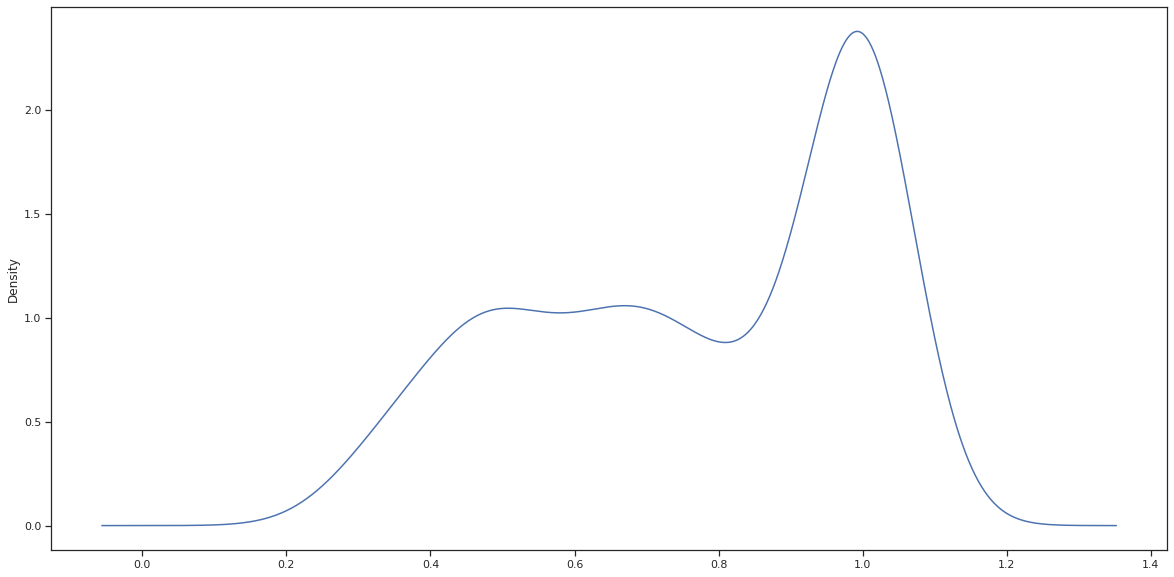

In [11]:
conv_rate_dt_df.conversion_rate.plot.kde()

**TODO**
* investigate 0 distance bucket
* replace all_sessions with session_data_new_test (for whole time frame)
* create conversion_rates table for whole time frame and save in BQ

## Analysis

`conversion_rates` based on delay and delivery fee

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext google.cloud.bigquery

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

from scipy import stats

sns.set(rc={'figure.figsize':(20,10)}, style="ticks", palette="deep6")

In [35]:
%%bigquery conversion_rates

WITH session_data AS (
  SELECT
    s.region,
    s.created_date,
    s.created_at,
    s.customer as session_customer,
    s.vendor as session_vendor,
    FLOOR(st_distance(o.vendor.location, o.customer.location)/500) * 500 as distance_bucket,
    ARRAY_LENGTH(s.vendors) as num_session_vendor_list,
    s.vendors as session_vendor_list,
    FLOOR(hzs.delay / 5) * 5 as delay_bucket,
  FROM
    `pricing.all_sessions` s
    INNER JOIN cl.orders o ON
      o.created_date = s.created_date
      AND o.platform_order_code = s.platform_order_code
    LEFT JOIN `dl.hurrier_zone_stats` hzs ON
      hzs.geo_zone_id = o.zone_id
      AND hzs.created_date = o.created_date
      AND hzs.country_code = o.country_code
      AND TIMESTAMP_TRUNC(o.order_placed_at, MINUTE) = TIMESTAMP_TRUNC(hzs.created_at, MINUTE)
  WHERE
    s.created_date >= "2020-02-19"
    AND o.created_date >= "2020-02-19"
    AND hzs.created_date >= "2020-02-19"
    AND o.country_code = "sg"
    AND hzs.country_code = "sg"
),
vendors_shown AS (
  SELECT
    v.id AS vendor_code,
    v.delivery_fee.total AS delivery_fee,
    s.delay_bucket,
    s.distance_bucket,
    s.created_date,
    EXTRACT(HOUR FROM s.created_at) as hour,
    COUNT(*) AS num_shown,
  FROM
    session_data s
    JOIN UNNEST(s.session_vendor_list) v
  GROUP BY 1, 2, 3, 4 , 5
),
vendors_ordered AS (
  SELECT
    session_vendor.id AS vendor_code,
    session_vendor.delivery_fee.total AS delivery_fee,
    s.delay_bucket,
    s.distance_bucket,
    s.created_date,
    EXTRACT(HOUR FROM s.created_at) as hour,
    COUNT(*) AS num_orders,
    ARRAY_AGG(s.num_session_vendor_list) AS num_vendors_shown,
  FROM session_data s
  GROUP BY 1, 2, 3, 4 , 5
)

SELECT
  vs.vendor_code,
  CAST(vs.delivery_fee AS FLOAT64) as delivery_fee,
  CAST(vs.delay_bucket AS FLOAT64) as delay_bucket,
  vs.distance_bucket as distance_bucket, 
  vo.num_vendors_shown,
  vs.num_shown,
  vo.num_orders,
  vo.hour,
  vo.num_orders / vs.num_shown AS conversion_rate,
FROM
  vendors_shown vs
  INNER JOIN vendors_ordered vo USING(vendor_code, delivery_fee, delay_bucket, hour, distance_bucket, preptime_bucket)
ORDER BY 1, 2, 3 , 4

In [7]:
conversion_rates["avg_num_vendors_shown"] = conversion_rates["num_vendors_shown"].apply(np.mean)

In [8]:
conversion_rates["delay_bucket"].value_counts()

 0.0     69934
 5.0     55487
 10.0    31692
-5.0     29627
 15.0    12721
 20.0     3977
 25.0     1070
 30.0      292
 60.0       79
 35.0       10
 40.0        1
Name: delay_bucket, dtype: int64

In [9]:
conversion_rates.dtypes

vendor_code               object
delivery_fee             float64
delay_bucket             float64
num_vendors_shown         object
num_shown                  int64
num_orders                 int64
hour                       int64
conversion_rate          float64
avg_num_vendors_shown    float64
dtype: object

In [10]:
df = conversion_rates[
        (conversion_rates["delay_bucket"].astype(float) < 25.0)
    ]\
    .groupby(["delay_bucket", "delivery_fee", "hour"])\
    .apply(lambda x: pd.Series({
        'conversion_rate_mean': np.average(x['conversion_rate'], weights=x['num_orders']), 
        'num_orders': x['num_orders'].sum(), 
        'num_unique_vendors': len(x['vendor_code'].unique())
    }))\
    .reset_index()

df["delivery_fee"] = df["delivery_fee"].astype(float)
df["delay_bucket"] = df["delay_bucket"].astype(float)

df['pseudo_revenue'] = df.conversion_rate_mean*df.delivery_fee

In [11]:
df["hour"] = (df["hour"] + 8) % 24#[df.delivery_fee=='2.49']

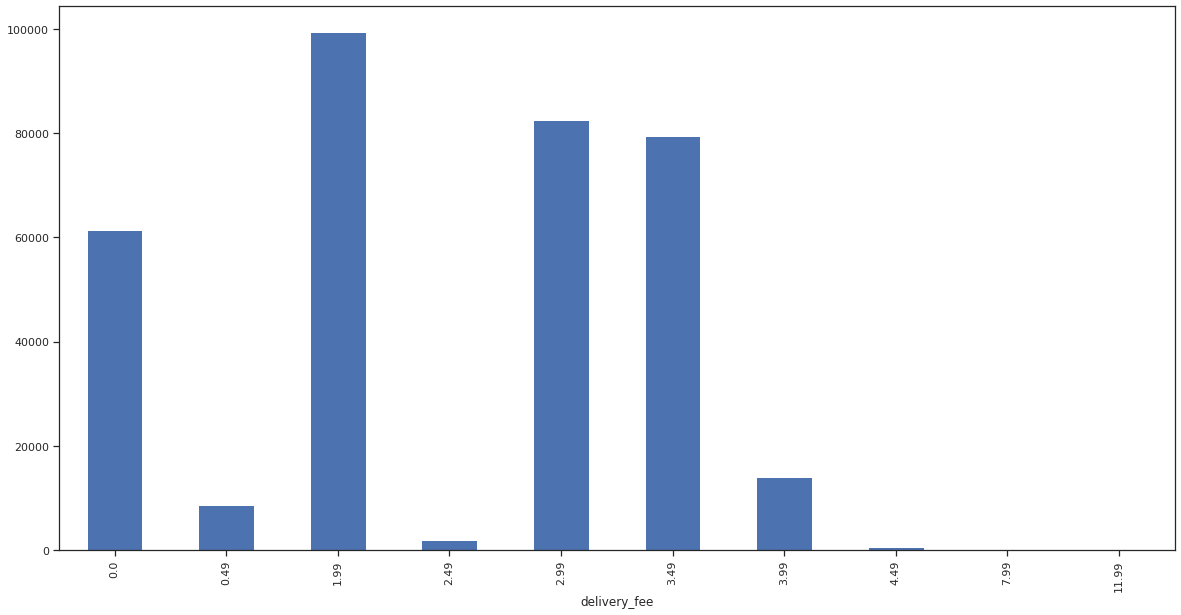

In [12]:
df.groupby("delivery_fee").sum().num_orders.plot(kind='bar')

In [13]:
df[(df.num_orders > 5000)]

,delay_bucket,delivery_fee,hour,conversion_rate_mean,num_orders,num_unique_vendors,pseudo_revenue
191,0.0,1.99,18,0.029922,6036.0,2531.0,0.059545
192,0.0,1.99,19,0.031726,5281.0,2294.0,0.063135
225,0.0,2.99,18,0.028023,6662.0,2041.0,0.083788
226,0.0,2.99,19,0.029296,5205.0,1849.0,0.087595


In [14]:
import matplotlib.pyplot as plt

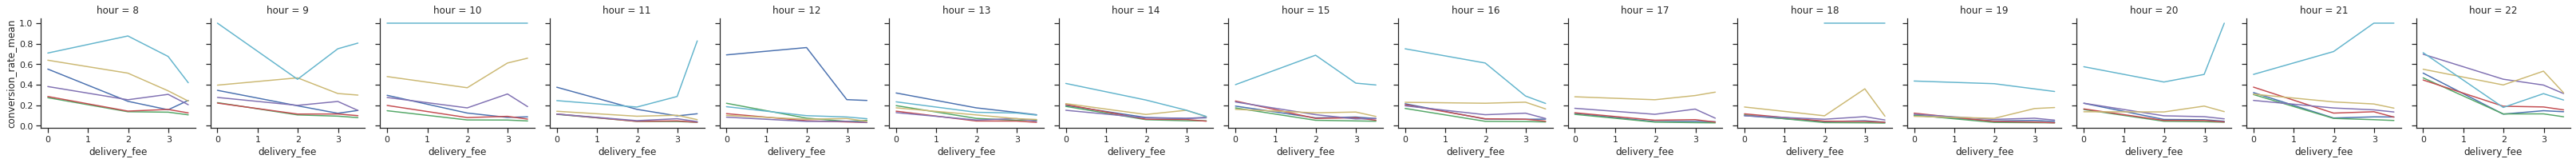

In [15]:
g = sns.FacetGrid(data=df[
        #(df.num_orders > 1000) 
        (df.delivery_fee != 0.49)
        & (df.delivery_fee != 2.49)
        & (df.delivery_fee < 3.99)
        & (df.hour >= 8)
        & (df.hour <= 22)
    ], col="hour", hue="delay_bucket")

g = g.map(plt.plot, "delivery_fee", "conversion_rate_mean")

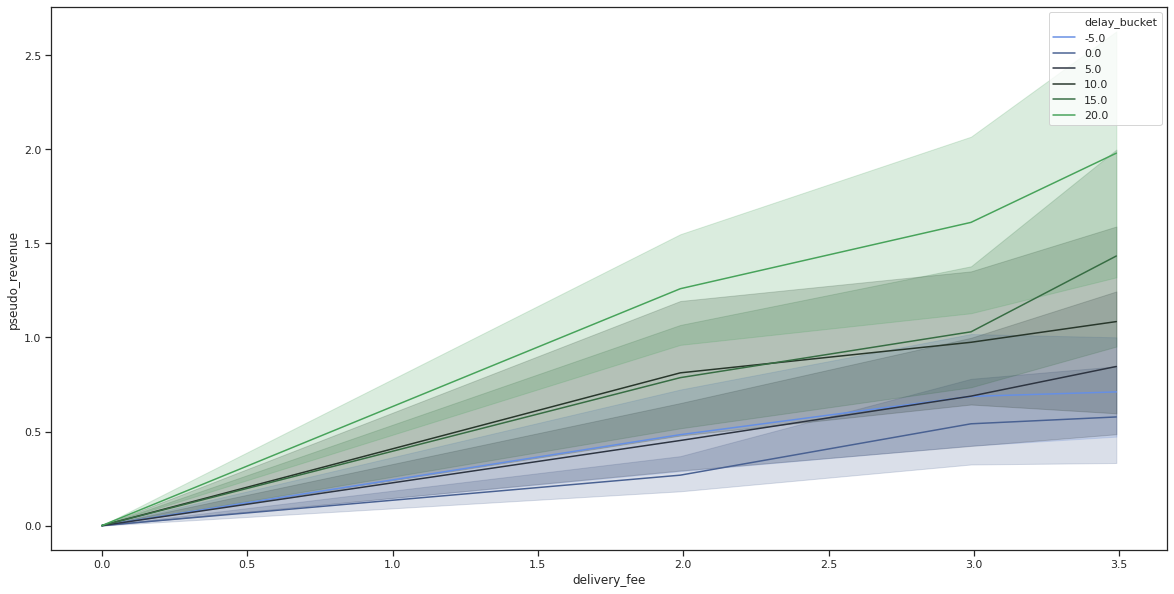

In [17]:
sns.lineplot(
    x="delivery_fee",
    y="pseudo_revenue",
    hue="delay_bucket",
    data=df[
        (df.delivery_fee != 0.49)
        & (df.delivery_fee != 2.49)
        & (df.delivery_fee < 3.99)
    ],
    palette=sns.diverging_palette(255, 133, l=60, n=len(df.delay_bucket.unique()), center="dark")
)

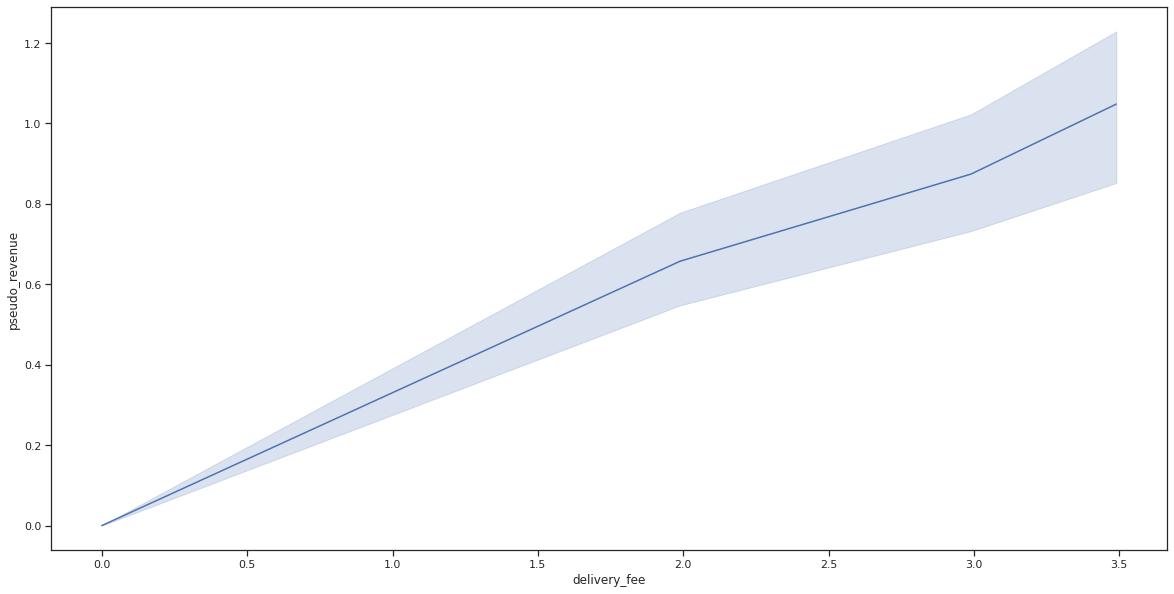

In [18]:
sns.lineplot(x="delivery_fee", y="pseudo_revenue",
    data=df[
        (df.delivery_fee != 0.49)
        & (df.delivery_fee != 2.49)
        & (df.delivery_fee < 3.99)
    ])

In [19]:
df.groupby("hour").agg({"num_orders": "sum"})

,num_orders
hour,
0,1862.0
1,1173.0
2,757.0
3,408.0
4,251.0
5,137.0
6,201.0
7,3.0
8,5985.0


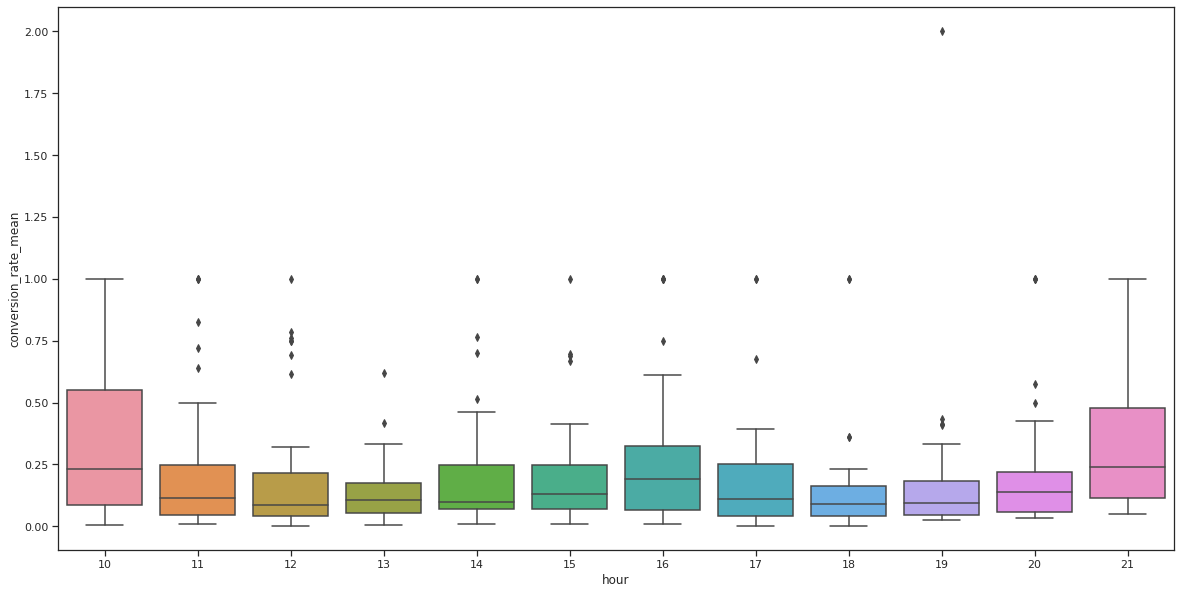

In [20]:
sns.boxplot(x="hour", y="conversion_rate_mean", data=df.groupby("hour").filter(lambda X: X.num_orders.sum() > 10000))

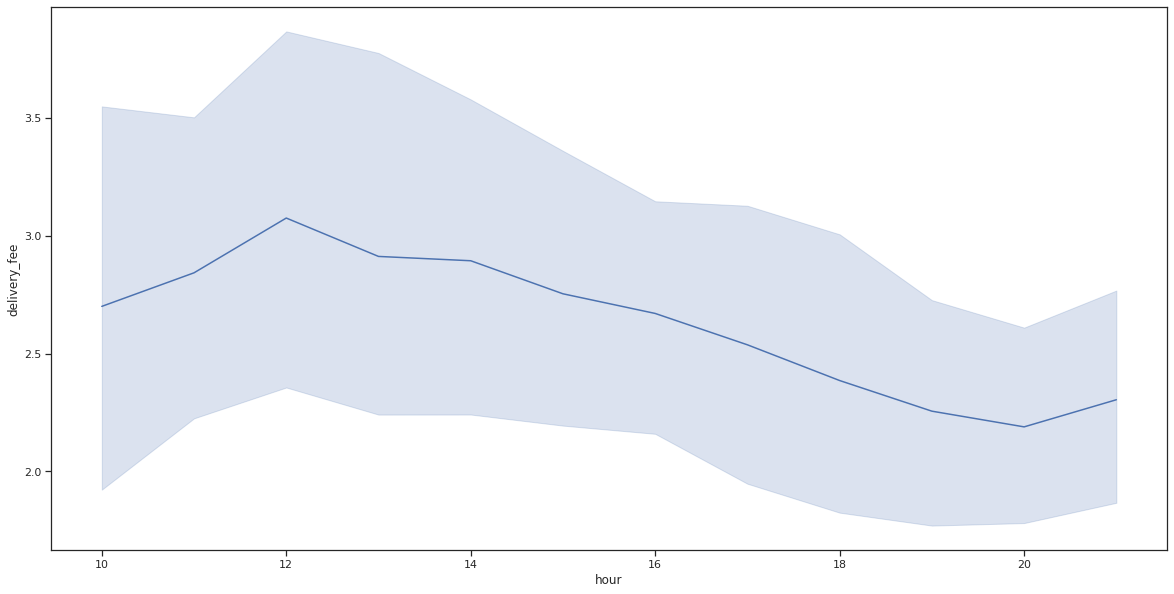

In [21]:
sns.lineplot(x="hour", y="delivery_fee", data=df.groupby("hour").filter(lambda X: X.num_orders.sum() > 10000))

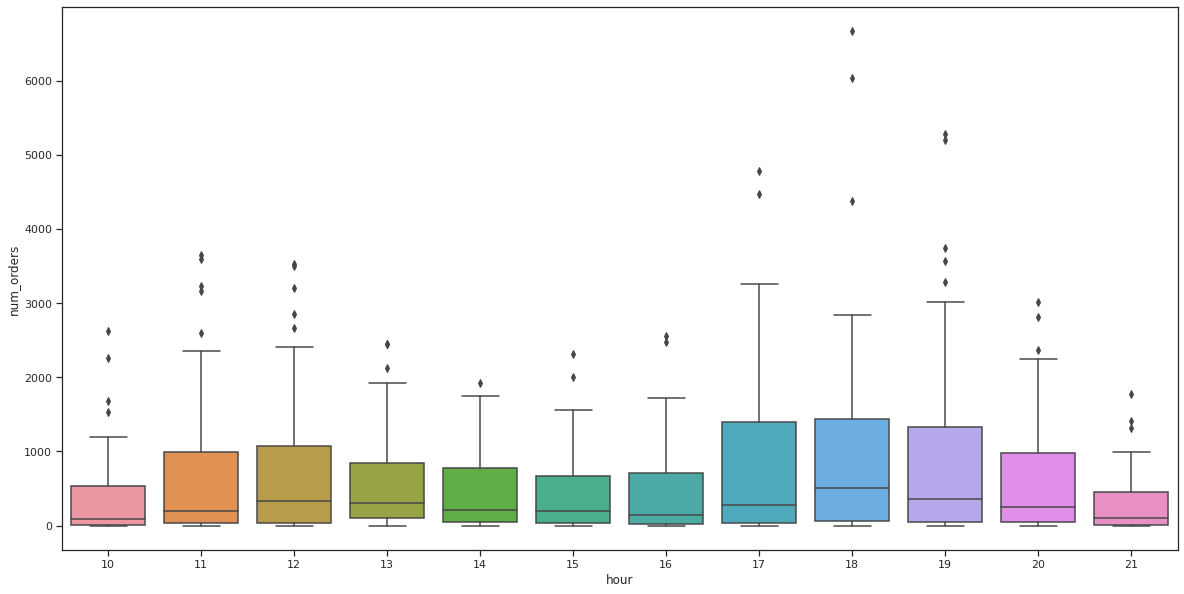

In [22]:
sns.boxplot(x="hour", y="num_orders", data=df.groupby("hour").filter(lambda X: X.num_orders.sum() > 10000))

In [23]:
df[df.delivery_fee==2.49]

,delay_bucket,delivery_fee,hour,conversion_rate_mean,num_orders,num_unique_vendors,pseudo_revenue
69,-5.0,2.49,23,1.000000,1.0,1.0,2.490000
204,0.0,2.49,8,0.916667,6.0,5.0,2.282500
205,0.0,2.49,9,0.700000,5.0,5.0,1.743000
206,0.0,2.49,10,1.000000,1.0,1.0,2.490000
207,0.0,2.49,12,0.785714,7.0,6.0,1.956429
208,0.0,2.49,13,0.333333,3.0,3.0,0.830000
209,0.0,2.49,14,0.250000,1.0,1.0,0.622500
210,0.0,2.49,15,0.666667,2.0,2.0,1.660000
211,0.0,2.49,16,1.000000,2.0,2.0,2.490000
212,0.0,2.49,17,0.394722,10.0,9.0,0.982858


In [24]:
df[(df.delivery_fee > 3.5) & (df.num_orders > 1800)]

,delay_bucket,delivery_fee,hour,conversion_rate_mean,num_orders,num_unique_vendors,pseudo_revenue


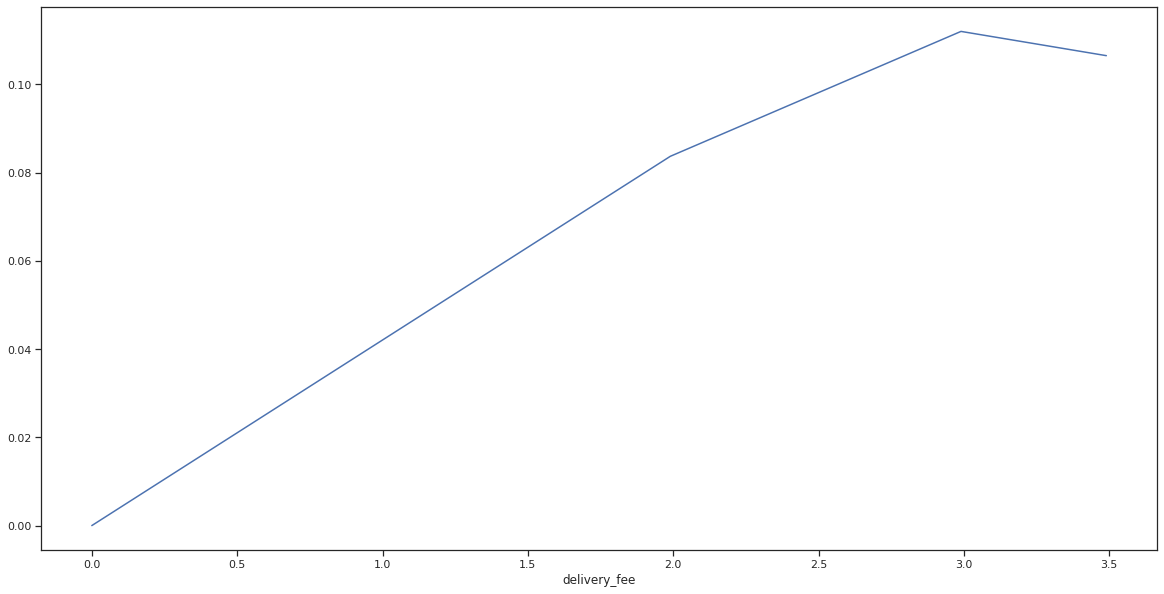

In [25]:

df[df.num_orders > 1800].groupby('delivery_fee').apply(lambda x: np.average(x['pseudo_revenue'], weights=x['num_orders'])).plot()
#sns.lineplot(x='delivery_fee', y='pseudo_revenue', data=df)

In [26]:
df["delay_bucket"] = df["delay_bucket"].astype(float)
sns.lineplot(x="delay_bucket", y="avg_num_vendors_shown", data=df[df["num_orders"] > 10], palette=sns.color_palette("Set1", len(conversion_rates["delay_bucket"].unique())))

ValueError: Could not interpret input 'avg_num_vendors_shown'

---

## Distance and Comission

In [ ]:
%%